## Mini Project: Youtube Channel Subscription Trend Forecasting with Prophet

**Objective**:  
The objective of this project is to forecast subscription trends and analyze the associated seasonality and residuals using Prophet. The model will predict subscription counts over time, calculate the uncertainty intervals for these predictions, and perform a detailed analysis of residuals and trends. The project aims to assess how well the model captures subscription fluctuations over a specified period, identify long-term trends, and analyze seasonal variations (both weekly and yearly). 

Additionally, the project seeks to evaluate the model’s prediction accuracy by calculating residuals and providing insights into subscription movements to inform business strategies.

In [1]:
#Import all necessary libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data Preparation & Loading 

In [93]:
#Define date range
start_date = "2020-02-02"
end_date = "2025-12-31"
date_range = pd.date_range(start = start_date, end = end_date, freq = "D")

In [94]:
#Simulate daily new subscribers
np.random.seed(42)
days = len(date_range)
growth_factor = np.linspace(1,3,days)
new_subscribers = np.random.poisson(lam = growth_factor * 5)
new_subscribers = np.maximum(new_subscribers, 0) #no -ve vals
total_subscribers = np.cumsum(new_subscribers)

In [95]:
youtube_data = pd.DataFrame({
    "Date": date_range,
    "New_subscribers": new_subscribers,
    "Total_subscribers": total_subscribers
})

In [96]:
youtube_data.to_csv("Youtube_subscribers.csv", index = False)

In [97]:
df = pd.read_csv("Youtube_subscribers.csv")
df=df.drop(df.columns[-1], axis = 1)
df.head(10)

,Date,New_subscribers
0,2020-02-02,5
1,2020-02-03,4
2,2020-02-04,4
3,2020-02-05,5
4,2020-02-06,5
5,2020-02-07,3
6,2020-02-08,5
7,2020-02-09,4
8,2020-02-10,6
9,2020-02-11,7


In [98]:
df.isna().sum()

Date               0
New_subscribers    0
dtype: int64

In [99]:
#!pip install fbprophet
from prophet import Prophet

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             2160 non-null   object
 1   New_subscribers  2160 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.9+ KB


In [101]:
df['Date'] = pd.to_datetime(df['Date']) #convert date col to datetime format

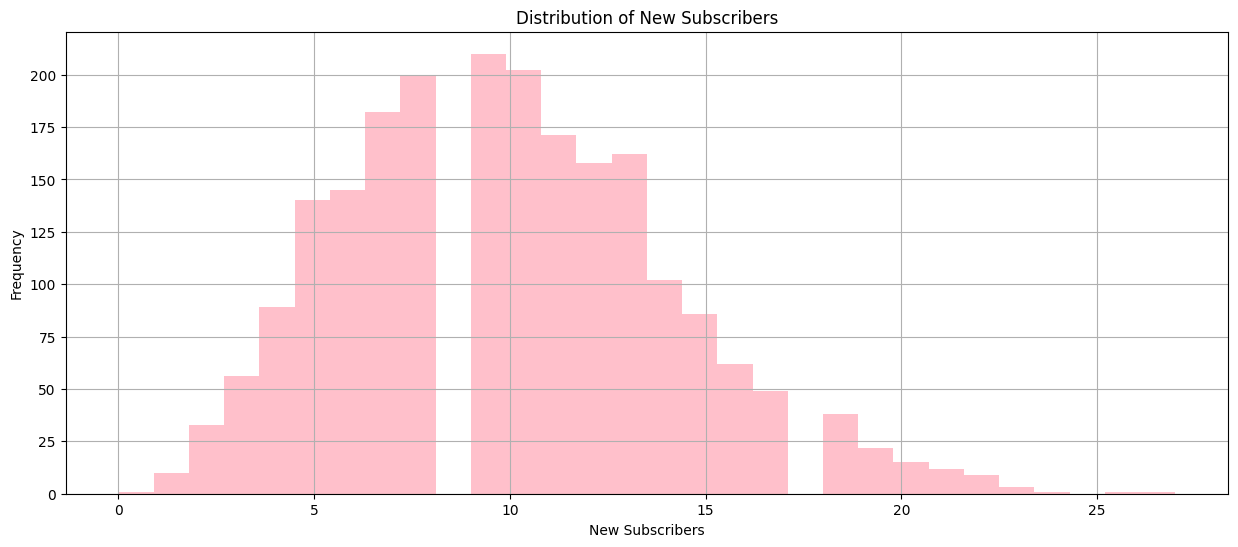

In [102]:
plt.figure(figsize=(15,6))
plt.hist(df['New_subscribers'], bins = 30, color = 'pink')
plt.title("Distribution of New Subscribers")
plt.xlabel("New Subscribers")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [103]:
daily_subscribers = df.groupby('Date')['New_subscribers'].sum()

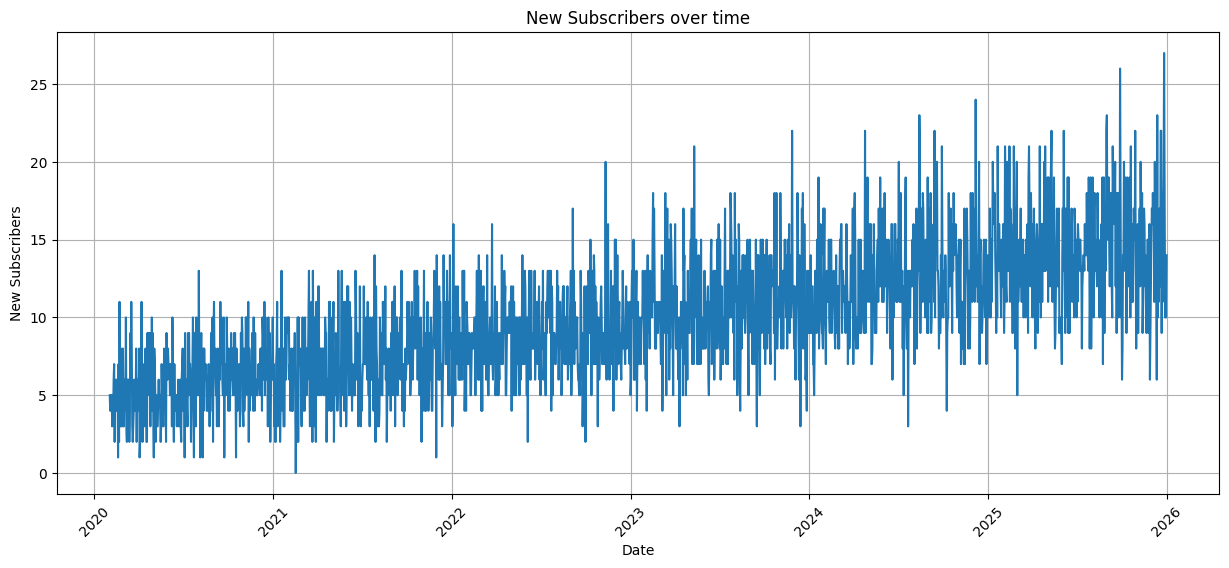

In [104]:
plt.figure(figsize=(15,6))
plt.plot(df['Date'],df['New_subscribers'])
plt.title("New Subscribers over time")
plt.xlabel("Date")
plt.ylabel("New Subscribers")
plt.xticks(rotation = 45)
plt.grid()
plt.show()

In [105]:
df.shape #too many data points, let's resample to monthly data

(2160, 2)

In [106]:
df_resampled = df.resample('ME', on = 'Date').sum() 
df_resampled.head()

,New_subscribers
Date,
2020-02-29,137
2020-03-31,159
2020-04-30,172
2020-05-31,151
2020-06-30,157


Text(0.5, 1.0, 'New Subscribers over time')

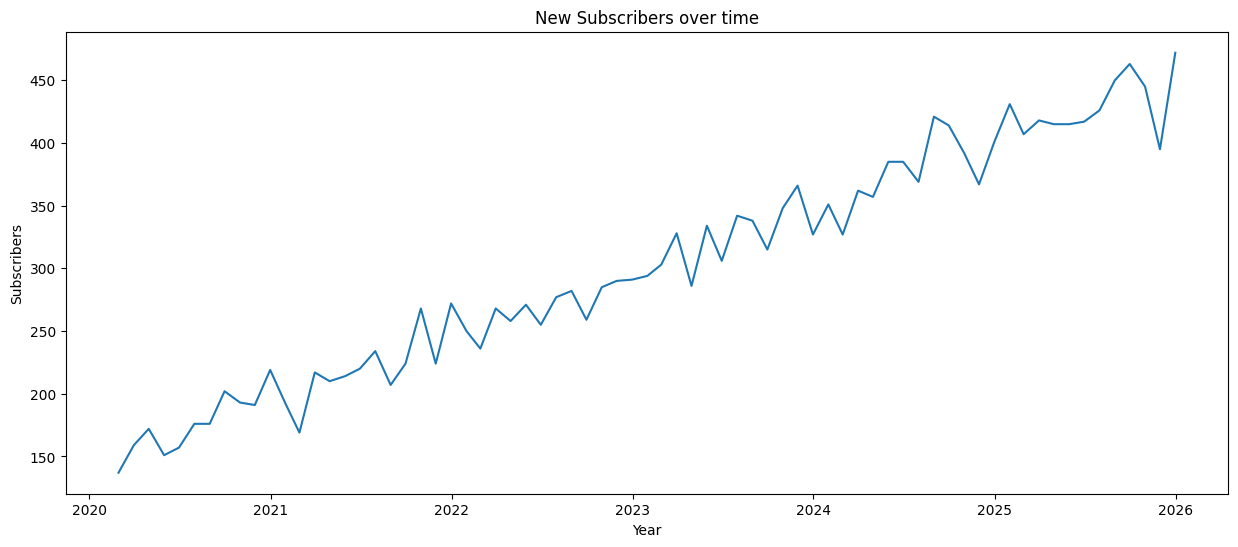

In [107]:
plt.figure(figsize=(15,6))
plt.plot(df_resampled.index, df_resampled['New_subscribers'])
plt.xlabel('Year')
plt.ylabel('Subscribers')
plt.title('New Subscribers over time')

df = df.rename(columns={'Date':'ds', 'New_subscribers':'y'})
df.head()

### Fitting the Prophet model to the data

Prophet is ideal for this project due to its ability to handle complex seasonal patterns, trends, and disruptions like holidays or events. Given the subscription data's long-term trends and periodic fluctuations, Prophet offers an intuitive approach to forecasting. Its robustness to missing data, outliers, and custom seasonalities ensures accurate and interpretable predictions, making it the perfect tool for reliable forecasting and informed business decisions.

In [109]:
model= Prophet(seasonality_mode = 'multiplicative', weekly_seasonality=False) 
model.fit(df)

18:20:39 - cmdstanpy - INFO - Chain [1] start processing
18:20:39 - cmdstanpy - INFO - Chain [1] done processing


### Forecasting subscribers for next 9 months from 2025-12-31

In [125]:
future = model.make_future_dataframe(periods = 9, freq ='MS')
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
2164,2026-05-01,15.494144,12.429794,20.088323,15.493741,15.494566,0.052499,0.052499,0.052499,0.052499,0.052499,0.052499,0.0,0.0,0.0,16.307577
2165,2026-06-01,15.639009,11.353984,19.190835,15.638471,15.639571,-0.015589,-0.015589,-0.015589,-0.015589,-0.015589,-0.015589,0.0,0.0,0.0,15.395206
2166,2026-07-01,15.779201,11.429662,19.015035,15.778520,15.779919,-0.039320,-0.039320,-0.039320,-0.039320,-0.039320,-0.039320,0.0,0.0,0.0,15.158768
2167,2026-08-01,15.924066,12.234531,19.974661,15.923203,15.924966,0.008628,0.008628,0.008628,0.008628,0.008628,0.008628,0.0,0.0,0.0,16.061458
2168,2026-09-01,16.068932,13.238189,20.759149,16.067926,16.070055,0.056541,0.056541,0.056541,0.056541,0.056541,0.056541,0.0,0.0,0.0,16.977479


In [126]:
forecast['yhat'].sum() #estimated total subscribers on 2026-09-01

np.float64(21515.409550668293)

### Plotting the forecast

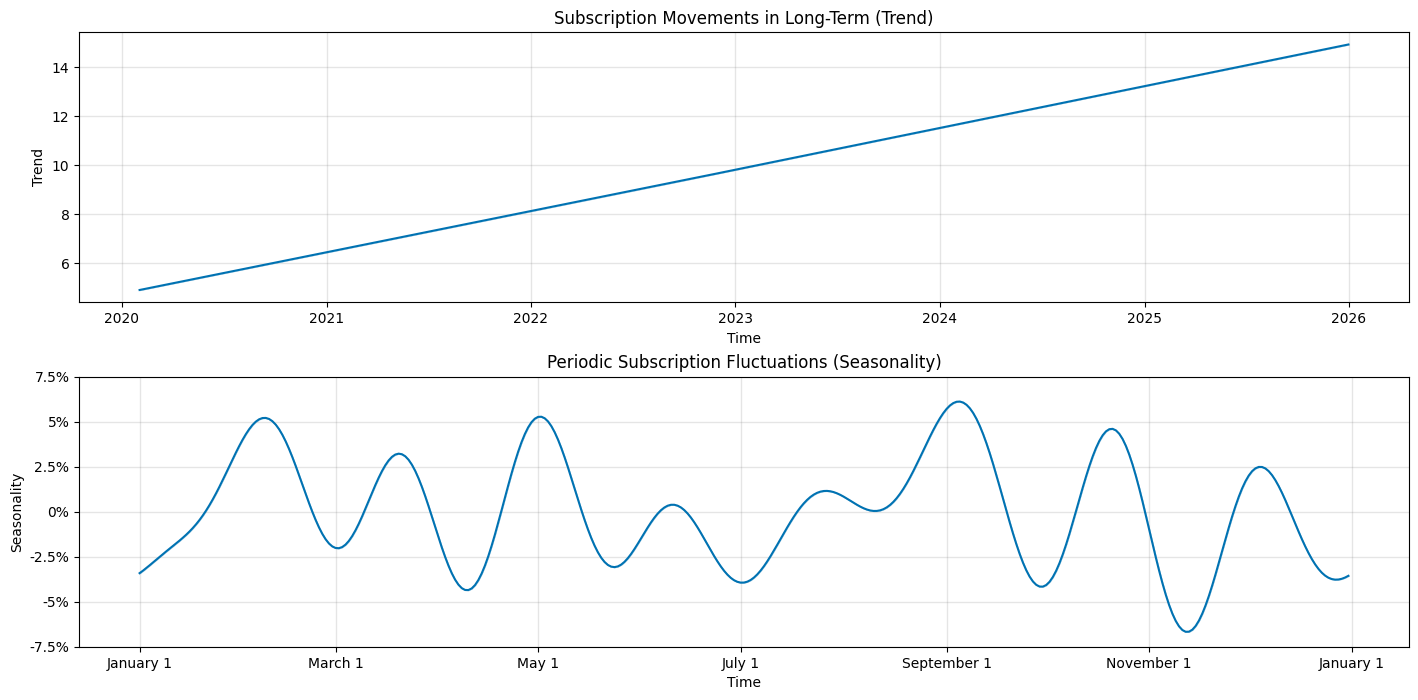

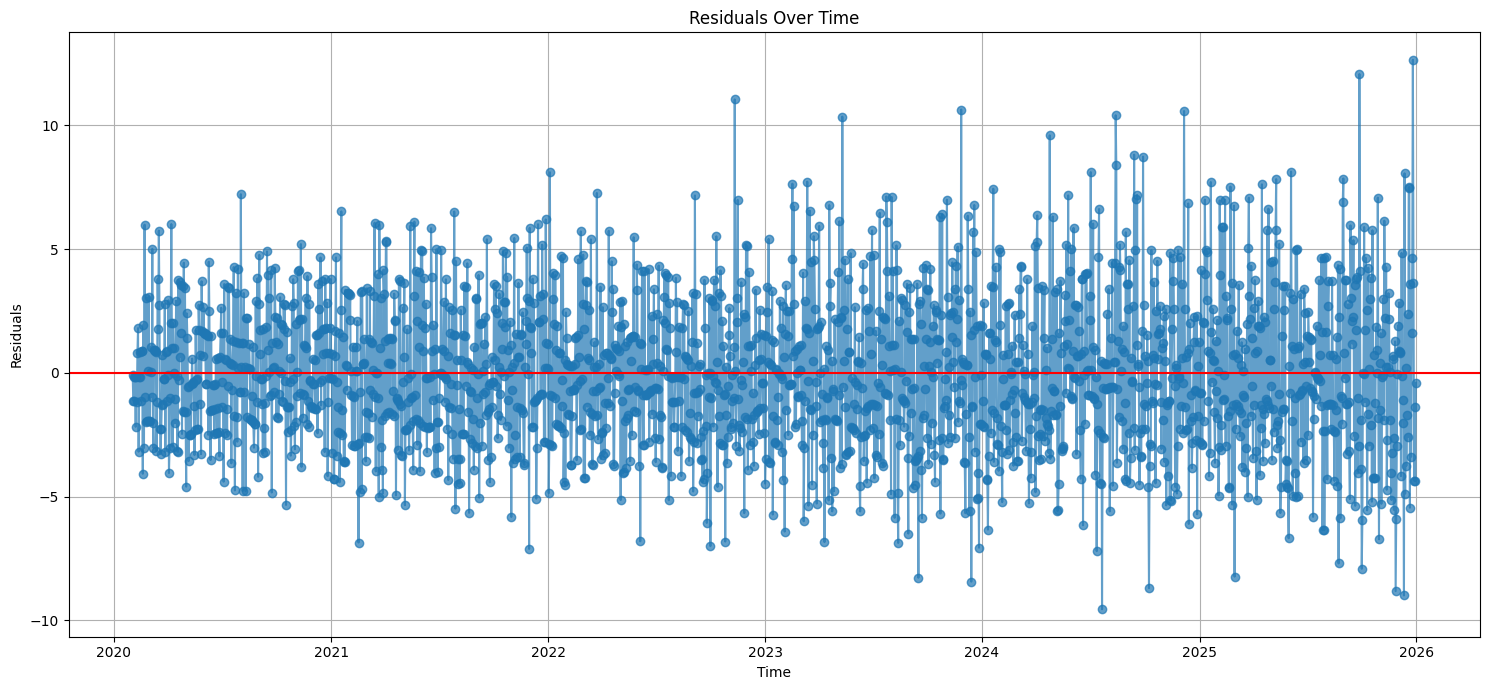

In [127]:
# Generate forecast
forecast = model.predict(df)

# Merge the original df with the forecast based on the 'ds' column (date)
df_with_forecast = pd.merge(df, forecast[['ds', 'yhat']], on='ds', how='left')

# Calculate residuals (difference between actual and predicted values)
df_with_forecast['residuals'] = df_with_forecast['y'] - df_with_forecast['yhat']

# Plot components
fig_components = model.plot_components(forecast)
fig_components.set_size_inches(15, 7)
fig_components.axes[0].set_title('Subscription Movements in Long-Term (Trend)')
fig_components.axes[0].set_xlabel('Time')
fig_components.axes[0].set_ylabel('Trend')
fig_components.axes[1].set_title('Periodic Subscription Fluctuations (Seasonality)')
fig_components.axes[1].set_xlabel('Time')
fig_components.axes[1].set_ylabel('Seasonality')

# Plot residuals over time
plt.figure(figsize=(15, 7))
plt.plot(df_with_forecast['ds'], df_with_forecast['residuals'], marker='o', linestyle='-', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='-')  # Add a horizontal line at y=0 for reference
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals Over Time')

plt.grid()
plt.tight_layout()
plt.show()
